In [35]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from file_functions import File

@tool
def information(file_path):
    'returns file information'
    val=File(file_location=file_path)
    return val.discribe_df()

tools=[information]
toolnode=ToolNode(tools=tools)

In [42]:
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, Tool
llm = Ollama(model="llama3.2")


In [72]:
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from langgraph.graph import StateGraph, END ,MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

def decision(state:MessagesState):
    a=input("should continue")
    if 'exit' == a.lower():
        return "end"
    else:
        return "continue"
    
def choose(state:MessagesState):
    # a=input('Query')
    a='analysis'
    if 'analysis' in a.lower():
        return 'analysis'

def analysis(state:MessagesState):
    systemprompt=[SystemMessage(content='You are a data analyst. you are provided infromatoion about a csv file now use that information to make a report.'),
    HumanMessage(content=information.func(r"C:\Users\ASUS\OneDrive\Desktop\code\datasets\protein.csv"))]
    response=llm.invoke(systemprompt)
    print(response)
    return {"messages": state['messages']+[response]}

    
def contin(state:MessagesState):
    a=input('what are you')
    systemprompt=[SystemMessage(content='you are a helpful assistant'),
    HumanMessage(content=a)]
    response = llm.invoke(systemprompt)
    print(response.content)
    return {"messages": state['messages']+[response]}

In [73]:
graph = StateGraph(MessagesState)
graph.add_node('dec1',lambda state:state)
graph.add_node('choose',lambda state:state)
graph.add_node('analysis',analysis)
graph.set_entry_point('dec1')
graph.add_conditional_edges(
    'dec1',
    decision,
    {
        "continue":"choose",
        "end": END,
    }
)
graph.add_conditional_edges(
    'choose',
    choose,
    {
        'analysis':'analysis',
        "fitting":END,
    }
)
# graph.add_edge('analysis','dec1')
app = graph.compile()

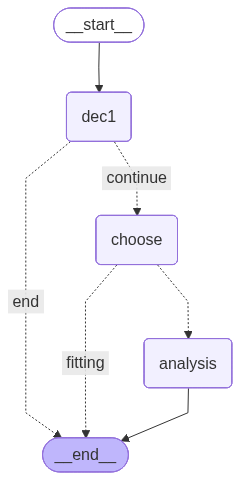

In [74]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
res = app.invoke({"messages": ["blablabla"]})
print(res['messages'])